In [1]:
import numpy as np
from sklearn import preprocessing, cluster
import sklearn
print("sklearn version: ", sklearn.__version__)
import pandas
from matplotlib import pyplot
import matplotlib

import podomics

sklearn version:  1.2.0


## Loading a dataset

In [2]:
omics = podomics.read_csv("examples/exampledata3.csv", sample="Sample", time="Timepoint", condition="Condition")
print(omics.data.head())
print("Timepoints:", omics.timepoints)

       Condition  Timepoint        10        43         2         0        16  \
Sample                                                                          
aT0R0          a       0.00  0.294415  0.012780  0.988288  1.000774  0.070487   
aT0R2          a       0.00  0.293859  0.006343  0.922625  1.059388  0.145908   
aT0R1          a       0.00  0.351795  0.010958  0.982960  1.008382  0.029968   
aT1R0          a       0.25  0.307706  0.132628  0.776740  0.807937  0.109115   
aT1R2          a       0.25  0.304130  0.146054  0.739624  0.813807  0.067468   

              30        33        48  ...        21        45        36  \
Sample                                ...                                 
aT0R0   0.033389  0.097109  0.042608  ...  0.115557  0.062764  0.059689   
aT0R2   0.014464  0.002039  0.020438  ...  0.079815  0.023210  0.018816   
aT0R1   0.050681  0.021210  0.038401  ...  0.033762  0.090298  0.034470   
aT1R0   0.033649  0.012068  0.241186  ...  0.036998  0.21

## Data rescaling

The recommended way to rescale the data is to divide each feature by a typical value, for example its maximum or median value. A good alternative can be a log-scaling. The implementations of these methods is illustrated below.

z-score normalization or similar is not recommended, since it removes difference in variance among features that may contain relevant timeseries information.

### Scaling by maximum value

Scaling with maximum value is the default in podomics and can be achieved by calling the `rescale()` method without any parameters.

In [3]:
omics_maxscaled = omics.rescale()
np.array([omics_maxscaled.data[f].max() for f in omics_maxscaled.features])

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

The output shows that all features in the rescaled dataset have a maximum value of 1.

### Scaling by median

Unfortunately there is now median scaler in the `sklearn.preprocessing` currently. We provide a custom `MedianScaler` class in the `dataset` module, that closely follows the implementation of the `MaxAbsScaler` class.

An instance of the `MedianScaler` class has to be passed to the `rescale()` method to do a scaling wit the median.

In [4]:
omics_medscaled = omics.rescale(method=podomics.dataset.MedianScaler())
np.array([omics_medscaled.data[f].median() for f in omics_medscaled.features])

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

The output shows that all features in the rescaled dataset have a median value of 1.

### Log scaling

TODO, use sklearn.preprocessing.FunctionTransformer

## Data plotting

(<Figure size 640x480 with 2 Axes>,
 array([<AxesSubplot: title={'center': 'Condition a'}, xlabel='Feature index', ylabel='Feature values'>,
        <AxesSubplot: title={'center': 'Condition b'}, xlabel='Feature index'>],
       dtype=object))

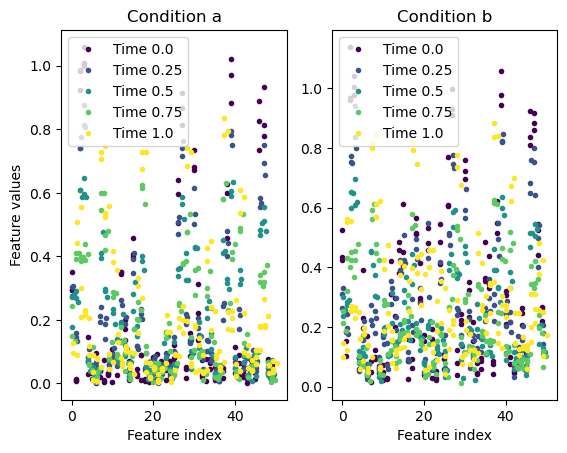

In [5]:
omics.plot(condition=["a", "b"])

Text(0.5, 1.0, 'Median scaled data - a')

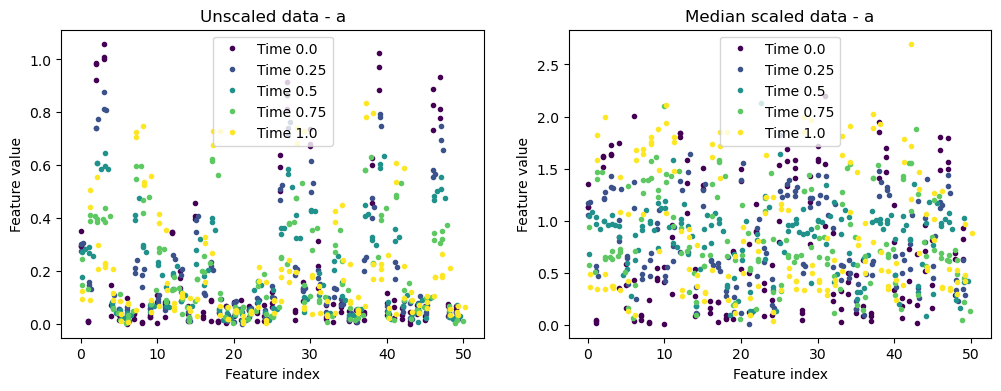

In [6]:
fig, axs = pyplot.subplots(1, 2, figsize=(12, 4))
omics.plot(ax=axs[0], condition="a")
omics_medscaled.plot(ax=axs[1], condition="a")
for ax in axs:
    ax.set_xlabel("Feature index")
    ax.set_ylabel("Feature value")
axs[0].set_title("Unscaled data - a")
axs[1].set_title("Median scaled data - a")

## POD computation

In the simplest version, a call to `podomics.POD` with a dataset as only argument runs the POD on all features and all samples. The results are immediately computed and stored in the created object's attributes. The results can then be further analysed with the plotting and analysis methods provided by the `POD` class.

Further relevant options are:
- **Clustering of features:** Pass a suitable method for clustering from the [`sklearn.cluster`](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.cluster) module.
  Recommended methods are [`KMeans`](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) and [`GaussianMixture`](https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html).
  Use the `cluster_components` keyword argument to the `POD` constructor to indicate the number of singular vectors / principal components to include in the cluster (counted from the first component in order of decreasing weight).
- **Selection of a subset of conditions:** to do the POD only for a part of the samples based on condition, pass a list with the identifiers of the relevant conditions as the `conditions` keyword argument to the `POD` constructor.
- **Selection of a subset of features:** pass a list with features for which to do the analysis as the `features` keyword argument to the `POD` constructor.

The call below runs a POD on the above dataset for the "a" condition only, but for all features.
It does clustering using `KMeans` using the first three components.
Note that the number of clusters to compute is fixed independently to 2 during the construction of the `KMeans` object.

In [7]:
import sklearn
cluster_method = cluster.KMeans(n_clusters=3, n_init='auto')
pod = podomics.POD(omics_medscaled, cluster=cluster_method, cluster_components=3)

### Plotting singular values

(<Figure size 640x480 with 1 Axes>,
 <AxesSubplot: xlabel='Component index', ylabel="<ufunc 'log'> singular values">)

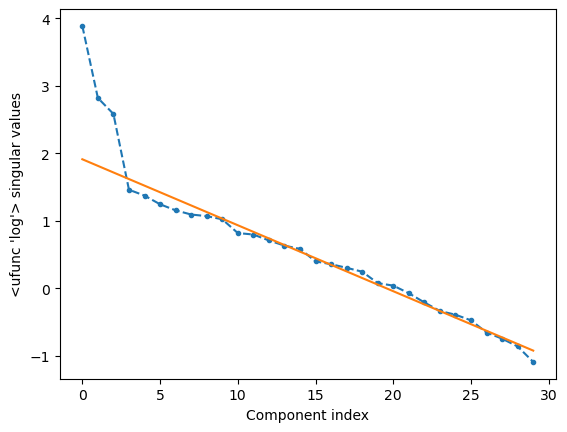

In [8]:
pod.plot_singular_values(trafo=np.log, fit_line=0.7)

### Plotting features in component space

Text(0, 0.5, 'Component 2')

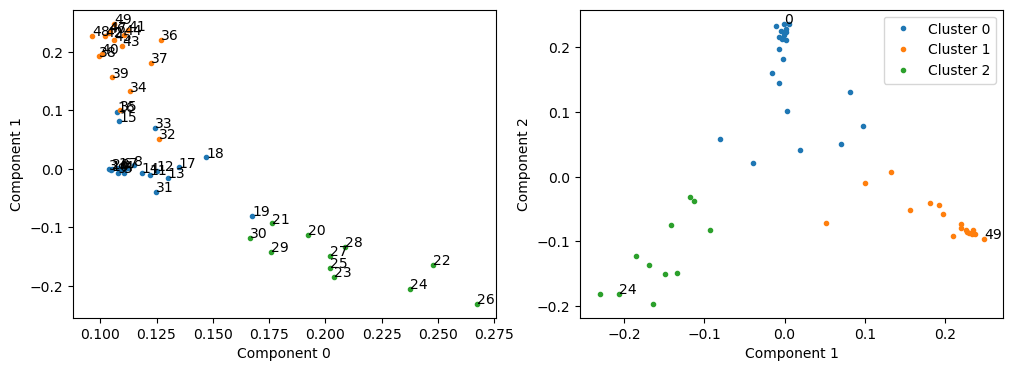

In [9]:
fig, axs = pyplot.subplots(1, 2, figsize=(12,4))
pod.plot_features(axs[0], components=(0, 1), annotate=True)
pod.plot_features(axs[1], components=(1, 2), annotate=['0', '24', '49'], labels='cluster')
axs[1].legend()
axs[0].set_xlabel("Component 0")
axs[0].set_ylabel("Component 1")
axs[1].set_xlabel("Component 1")
axs[1].set_ylabel("Component 2")

### Plotting samples in component space

Text(0, 0.5, 'Component 2')

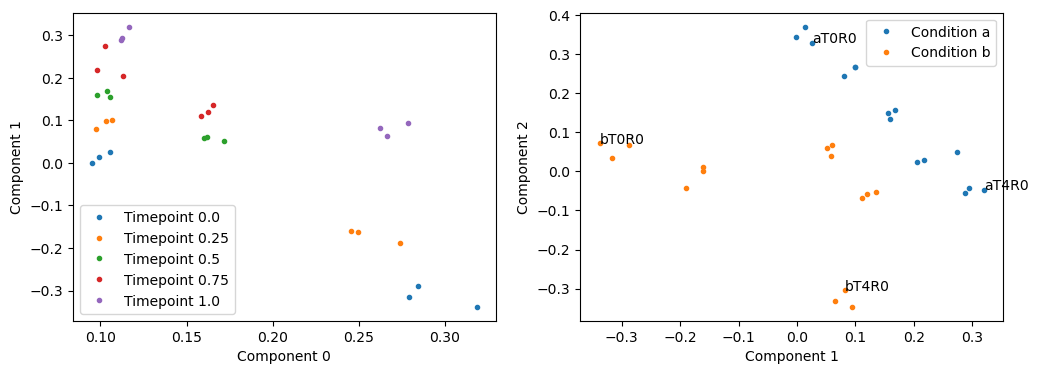

In [14]:
fig, axs = pyplot.subplots(1, 2, figsize=(12,4))
pod.plot_samples(axs[0], components=(0, 1), labels='time')
axs[0].legend()
pod.plot_samples(axs[1], components=(1, 2), annotate=['aT0R0', 'aT4R0', 'bT0R0', 'bT4R0'], labels='condition')
axs[1].legend()
axs[0].set_xlabel("Component 0")
axs[0].set_ylabel("Component 1")
axs[1].set_xlabel("Component 1")
axs[1].set_ylabel("Component 2")

In [ ]:
%debug

> /opt/anaconda3/envs/omics310/lib/python3.10/site-packages/pandas/core/indexes/base.py(3805)get_loc()
   3803                 return self._engine.get_loc(casted_key)
   3804             except KeyError as err:
-> 3805                 raise KeyError(key) from err
   3806             except TypeError:
   3807                 # If we have a listlike key, _check_indexing_error will raise

ipdb> u
> /opt/anaconda3/envs/omics310/lib/python3.10/site-packages/pandas/core/frame.py(3805)__getitem__()
   3803             if self.columns.nlevels > 1:
   3804                 return self._getitem_multilevel(key)
-> 3805             indexer = self.columns.get_loc(key)
   3806             if is_integer(indexer):
   3807                 indexer = [indexer]

ipdb> u
> /Users/waldherr/Documents/research/projects/2022-omics-pod/podomics/pod.py(396)plot_samples()
    394                             ax.plot(plotsamples[(components[0])], plotsamples[(components[1])], label=f"{self.ds.condition} {c}", **kwar

ipdb> p c
'a'
ipdb> p plotsamples
       Condition  Timepoint        10        43         2         0        16  \
Sample                                                                          
aT0R0          a       0.00  1.131383  0.045769  1.621280  1.631502  0.844819   
aT0R2          a       0.00  1.129246  0.022715  1.513560  1.727058  1.748764   
aT0R1          a       0.00  1.351884  0.039241  1.612540  1.643906  0.359174   
aT1R0          a       0.25  1.182456  0.474967  1.274237  1.317132  1.307785   
aT1R2          a       0.25  1.168716  0.523050  1.213349  1.326702  0.808628   
aT1R1          a       0.25  1.058127  0.571527  1.218340  1.426817  1.012269   
aT2R2          a       0.50  1.083928  0.917801  0.963092  0.957583  0.482906   
aT2R1          a       0.50  0.680475  0.965972  0.998717  0.971272  0.845252   
aT2R0          a       0.50  1.042007  1.038774  1.001283  1.051734  0.951057   
aT3R2          a       0.75  0.506519  1.464960  0.652302  0.664106  0.5077

In [25]:
pod.sample_weights[0]

Sample
aT0R0    0.105564
aT0R2    0.095276
aT0R1    0.099139
aT1R0    0.106454
aT1R2    0.097393
aT1R1    0.103153
aT2R2    0.103626
aT2R1    0.097888
aT2R0    0.105724
aT3R2    0.102631
aT3R0    0.113174
aT3R1    0.097893
aT4R2    0.111689
aT4R0    0.116580
aT4R1    0.112767
bT0R0    0.318308
bT0R2    0.279314
bT0R1    0.284223
bT1R1    0.245541
bT1R0    0.274101
bT1R2    0.249755
bT2R0    0.159941
bT2R2    0.171974
bT2R1    0.162113
bT3R2    0.158155
bT3R1    0.162436
bT3R0    0.165341
bT4R2    0.278586
bT4R1    0.266253
bT4R0    0.262099
Name: 0, dtype: float64

In [10]:
average_weights = pod.interpolate_sample_weights()
average_weights

,Condition,0,1,2,3,4,5,6,7,8,...,20,21,22,23,24,25,26,27,28,29
Timepoint,,,,,,,,,,,,,,,,,,,,,
0.00,b,0.293948,-0.314145,0.058003,0.041518,-0.037573,-0.207798,0.149012,-0.224326,-0.018811,...,-0.052167,0.031556,0.046931,0.017675,0.061748,0.023750,0.010554,0.005183,0.012810,0.019069
0.25,b,0.256466,-0.170348,-0.011150,-0.164264,0.037534,0.205474,-0.161928,0.095401,0.065337,...,0.087857,-0.015571,0.005527,-0.069064,0.030999,-0.053116,0.006210,0.000516,-0.132898,-0.110952
0.50,b,0.164676,0.056660,0.055932,0.101097,0.024939,-0.109158,0.000486,0.155799,-0.033004,...,-0.092031,0.062353,-0.035839,0.107202,-0.247599,0.032915,0.106327,0.015482,-0.023048,0.121473
0.75,b,0.161977,0.121860,-0.060070,-0.033369,0.062841,-0.147036,-0.093365,0.051886,0.074563,...,0.066371,0.024779,-0.222610,-0.015183,0.019890,-0.210959,0.088335,0.008561,0.164352,0.065104
1.00,b,0.268979,0.080046,-0.327619,0.047706,-0.019494,0.145163,0.024085,0.101766,-0.086436,...,-0.020775,-0.060385,0.027356,0.025767,-0.004286,0.099496,-0.093640,-0.014915,0.064686,0.012616
0.00,a,0.099993,0.013048,0.348099,0.044480,0.031231,0.126508,0.004478,0.178243,-0.101073,...,0.058127,-0.023609,0.179952,-0.072221,-0.043506,-0.077560,-0.047595,-0.040367,0.137174,0.024587
0.25,a,0.102333,0.093272,0.260256,-0.035069,-0.065501,0.074228,-0.003568,-0.046823,0.033601,...,0.011670,-0.048490,-0.199145,0.127543,0.086761,0.120046,-0.119017,-0.049455,0.131232,-0.017188
0.50,a,0.102413,0.160956,0.146620,0.030827,0.060637,-0.001668,-0.019432,-0.049353,0.031883,...,-0.106757,0.011698,-0.084847,-0.120394,-0.025223,0.117671,0.075824,0.154962,-0.347897,0.004755
0.75,a,0.104566,0.232158,0.034120,-0.104391,-0.027824,-0.015898,-0.073885,-0.185178,0.059789,...,0.010651,-0.013172,0.125153,0.098431,0.125598,-0.079758,0.058426,-0.032635,-0.020067,-0.065741


In [11]:
df = pod.sample_weights
[df[df[pod.ds.condition]==c] for c in pod.ds.condition_list]
# [df[df[pod.ds.condition]==c].groupby(pod.ds.time).mean() for c in pod.ds.condition_list]

[       Condition  Timepoint         0         1         2         3         4  \
 Sample                                                                          
 bT0R0          b       0.00  0.318308 -0.338099  0.072088  0.622088 -0.269768   
 bT0R2          b       0.00  0.279314 -0.316089  0.035566 -0.086822  0.566504   
 bT0R1          b       0.00  0.284223 -0.288247  0.066356 -0.410712 -0.409455   
 bT1R1          b       0.25  0.245541 -0.160126 -0.000155 -0.246509 -0.083980   
 bT1R0          b       0.25  0.274101 -0.189400 -0.043708  0.095370  0.095751   
 bT1R2          b       0.25  0.249755 -0.161517  0.010414 -0.341651  0.100832   
 bT2R0          b       0.50  0.159941  0.058326  0.039527  0.147681  0.071259   
 bT2R2          b       0.50  0.171974  0.051867  0.060187  0.059703 -0.063818   
 bT2R1          b       0.50  0.162113  0.059787  0.068081  0.095908  0.067376   
 bT3R2          b       0.75  0.158155  0.111049 -0.068217 -0.098500  0.034779   
 bT3R1          

In [12]:
pod_result = podomics.POD(podomics.read_csv("examples/exampledata1.csv", sample="Sample"))
average_weights = pod_result.interpolate_sample_weights()

In [13]:
print(average_weights.iloc[:2,:3])

                  0         1         2
Timepoint                              
0.00      -0.307343 -0.320584  0.245403
0.25      -0.279958 -0.144988 -0.251014


(<Figure size 640x480 with 2 Axes>,
 array([<AxesSubplot: title={'center': 'Component #1'}, xlabel='Timepoint', ylabel='Weight'>,
        <AxesSubplot: title={'center': 'Component #2'}, xlabel='Timepoint'>],
       dtype=object))

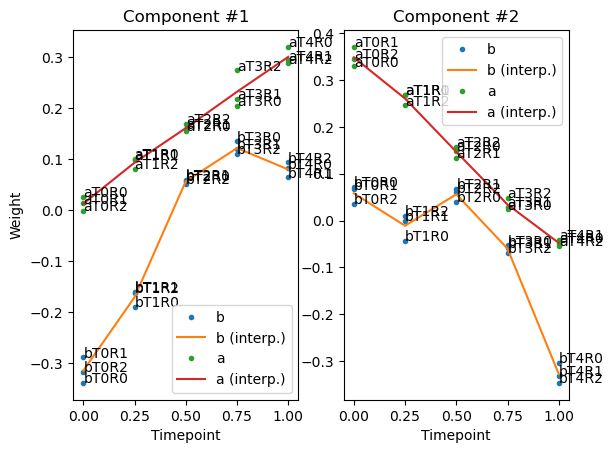

In [14]:
pod.plot_sample_weights(interpolate=True, components=[1, 2], labels=True)

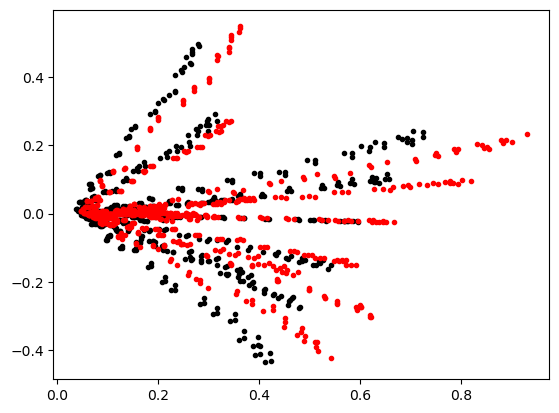

In [15]:
pod_result = podomics.POD(podomics.read_csv("examples/exampledata3.csv", sample="Sample", condition="Condition"))
fig, axs = pyplot.subplots(1, 1)
pod_result.plot_feature_data_in(axs, condition="a", c='k')
pod_result.plot_feature_data_in(axs, condition="b", c='r')
